## Median Beach Timing Notebook


In [1]:
from cmocean import cm
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.cm as mplcm
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
landcolour = 'papayawhip'
plt.rcParams['font.size'] = 15

In [16]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [17]:
minColor = 0.1
maxColor = 0.85
thermal_r_t = truncate_colormap(cm.thermal_r, minColor, maxColor)
mydiscrete = truncate_colormap(cm.thermal_r, 0.1, 0.85, 4)

In [3]:
minoil = 25 # litres per grid cell

In [4]:
#mesh = xr.open_dataset('~/MEOPAR/grid/mesh_mask201702.nc')
mesh = xr.open_dataset('~/Documents/MEOPAR/grid/mesh_mask201702.nc')
tmask = 1- mesh.tmask[0, 0]

In [6]:

data3d_7 = xr.open_dataset('/home/sallen/Documents/MIDOSS/MIDOSS_aggregated_merged.nc')

In [7]:
data3d_7

<xarray.Dataset>
Dimensions:                                (RunId: 723, x: 240, y: 270, z: 40)
Coordinates:
  * RunId                                  (RunId) object 'A-0' 'A-1' ... 'E-99'
  * z                                      (z) int64 0 1 2 3 4 ... 36 37 38 39
  * y                                      (y) int64 500 501 502 ... 767 768 769
  * x                                      (x) int64 100 101 102 ... 337 338 339
Data variables:
    OilWaterColumnOilVol_surface_presence  (RunId, y, x) float64 ...
    OilWaterColumnOilVol_below_presence    (RunId, y, x) float64 ...
    OilWaterColumnOilVol_surface_conc      (RunId, y, x) float64 ...
    OilWaterColumnOilVol_below_conc        (RunId, z) float64 ...
    Beaching_Time                          (RunId, y, x) datetime64[ns] ...
    Beaching_Volume                        (RunId, y, x) float64 ...
    OilType                                (RunId) object ...

In [22]:
jmin, jmax = data3d_7.x.values[0]+1, data3d_7.x.values[-1]+2
imin, imax = data3d_7.y.values[0]+1, data3d_7.y.values[-1]+2

In [8]:
beachtime = (np.array(data3d_7.Beaching_Time - data3d_7.Beaching_Time.min(axis=1).min(axis=1))
              ) /  np.timedelta64(1, 's') /3600./24.

In [9]:
beachtime.shape

(723, 270, 240)

In [10]:
beached = np.ma.masked_array(beachtime, data3d_7.Beaching_Volume < minoil/1000)


In [12]:
median = np.ma.median(beached, axis=0)

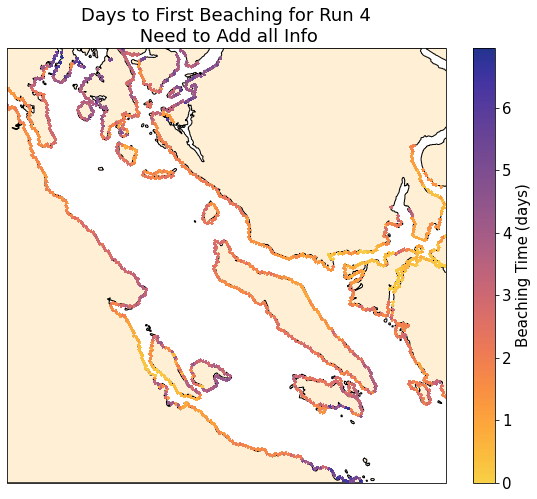

In [18]:
fig = plt.figure(figsize=(10, 8))
xlim, ylim = [-125.3, -123.9], [49.3, 50.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor=landcolour))
C = ax.pcolormesh(
    mesh.nav_lon[imin:imax, jmin:jmax], mesh.nav_lat[imin:imax, jmin:jmax], median,
     transform=crs.PlateCarree(), zorder=2, cmap=thermal_r_t, vmin=0,
)
cb = fig.colorbar(C, ax=ax);
cb.set_label('Beaching Time (days)')
ax.set_title("Days to First Beaching for Run 4\n Need to Add all Info");
fig.savefig('BeachingTime_latlon.png');

Try with Scatter Instead

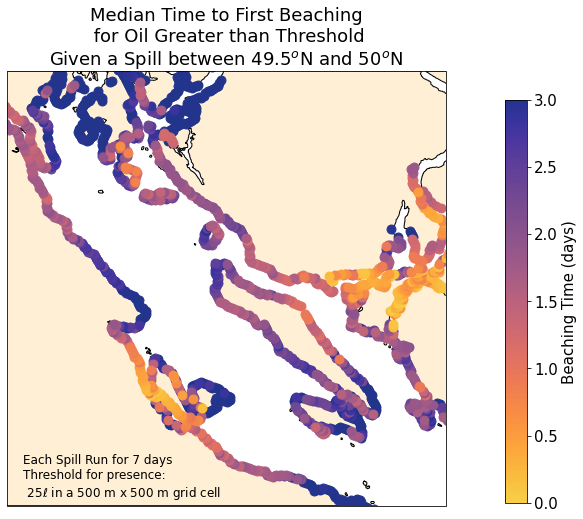

In [30]:
colormap2 = thermal_r_t
colormap = 'cmo.thermal_r'
dlat = mesh.nav_lat[imax, jmax] - mesh.nav_lat[imax-1, jmax-1]
dlon = mesh.nav_lon[imax, jmax] - mesh.nav_lon[imax-1, jmax-1]
bounds = np.arange(0, 3.5, 0.5)
normalize = colors.BoundaryNorm(bounds, thermal_r_t.N)
normalize = colors.Normalize(vmin=0, vmax=3)
fig = plt.figure(figsize=(10, 8))
xlim, ylim = [-125.3, -123.9], [49.3, 50.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor=landcolour))

for bt in range(6, -1, -1):
    for ii in range(imin, imax):
        for jj in range(jmin, jmax):
            if (median[ii-imin, jj-jmin] > bt) and (median[ii-imin, jj-jmin] < bt+1):
                ax.scatter(mesh.nav_lon[ii, jj] + dlon/2, mesh.nav_lat[ii, jj] + dlat/2, 
                           c=[median[ii-imin, jj-jmin]], marker='o', s=80, transform=crs.PlateCarree(), 
                           zorder=2, cmap=colormap2, norm=normalize)
#cb = fig.colorbar(C, ax=ax);
cax = fig.add_axes([0.9, 0.13, 0.03, 0.7])
cb = colorbar.ColorbarBase(cax, cmap=colormap2, norm=normalize)
cb.set_label('Beaching Time (days)')
ax.set_title("Median Time to First Beaching\n for Oil Greater than Threshold\nGiven a Spill between 49.5$^o$N and 50$^o$N");
ax.text(-125.25, 49.32, f'Each Spill Run for 7 days\nThreshold for presence:\n {minoil}$\ell$ in a 500 m x 500 m grid cell',
       transform=crs.PlateCarree(), fontsize=12)
fig.savefig(f'MedianTime_scatter_latlon_{minoil}.png', dpi=200);